In [21]:
import pandas as pd
import numpy as np
from numpy import percentile
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use({'figure.facecolor':'white'})
from sklearn.preprocessing import StandardScaler
from pyod.models.hbos import HBOS
from pyod.models.abod import ABOD
from pyod.models.lof import LOF
from pyod.models.cblof import CBLOF

### Data Import

In [22]:
df = pd.read_csv('dataset.csv', parse_dates=['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130511 entries, 0 to 130510
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   ou        130511 non-null  float64       
 1   datetime  130511 non-null  datetime64[ns]
 2   cheques   130511 non-null  int64         
 3   rto       130511 non-null  float64       
 4   n_sku     130511 non-null  int64         
 5   cnt       130511 non-null  int64         
 6   cashnum   130511 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 7.0 MB


In [23]:
df.head()

,ou,datetime,cheques,rto,n_sku,cnt,cashnum
0,468.0,2019-11-16 08:00:00,34,8003.0,137,173,3
1,468.0,2019-11-16 09:00:00,40,20129.0,283,517,2
2,468.0,2019-11-16 10:00:00,41,15782.0,185,227,2
3,468.0,2019-11-16 11:00:00,63,39451.0,386,659,4
4,468.0,2019-11-16 12:00:00,84,57330.0,635,992,4


### Visualization timeseries

In [24]:
def show_plots(df, columns, anomaly_column=None):
    fig, axs = plt.subplots(len(columns), 1, sharex=True, constrained_layout=True, figsize=(12,10))
    for i in range(len(columns)):
        c = columns[i]

        axs[i].plot(dd.index, df[c], color='gray',label='Normal')

        if anomaly_column:
            a = df.loc[df[anomaly_column] == 1, [c]] #anomaly
            axs[i].scatter(a.index, a[c], color='red', label='Anomaly')

        axs[i].xaxis_date()
        axs[i].set_title(c)
        plt.xlabel('Date')
    plt.show()

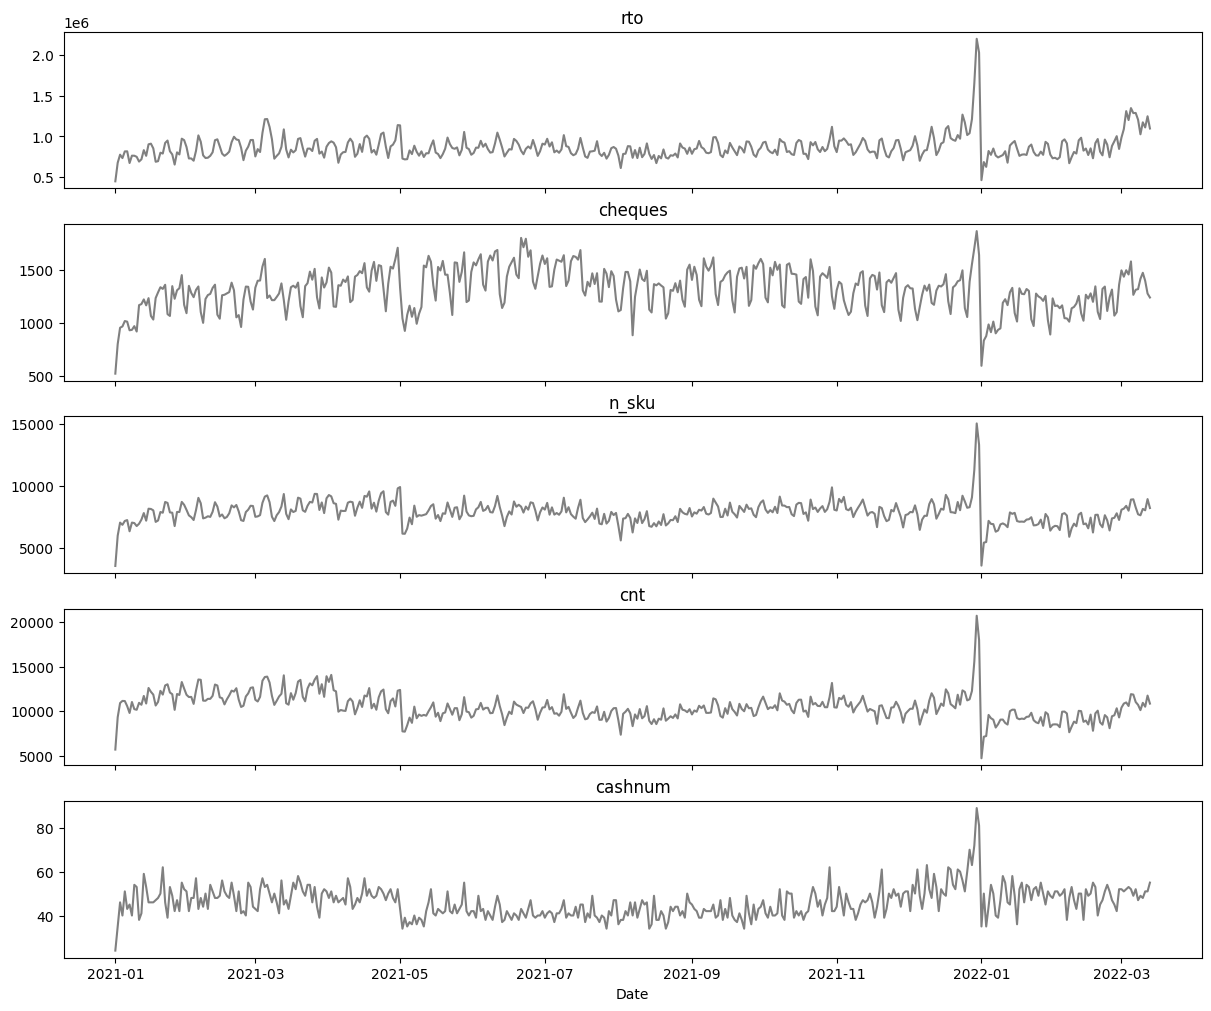

In [25]:
columns = ['rto', 'cheques', 'n_sku', 'cnt', 'cashnum']
for ou in df['ou'].unique()[:1]:
    dd = df[df['ou']==ou]
    dd = dd.set_index('datetime')['2021-01-01':'2022-03-15']
    dd = dd[columns].resample('D').sum()

    show_plots(dd, columns)

In [26]:
outliers_fraction = 0.05
random_state = np.random.RandomState(42)

### HBOS, ABOD, LOF, CBLOF

In [27]:
HBOS_detector= HBOS(contamination=outliers_fraction)
ABOD_detector= ABOD(contamination=outliers_fraction)
lof_detector = LOF(n_neighbors=20, contamination=outliers_fraction)
cblof_detector = CBLOF(contamination=outliers_fraction, random_state=random_state)

ou: 468


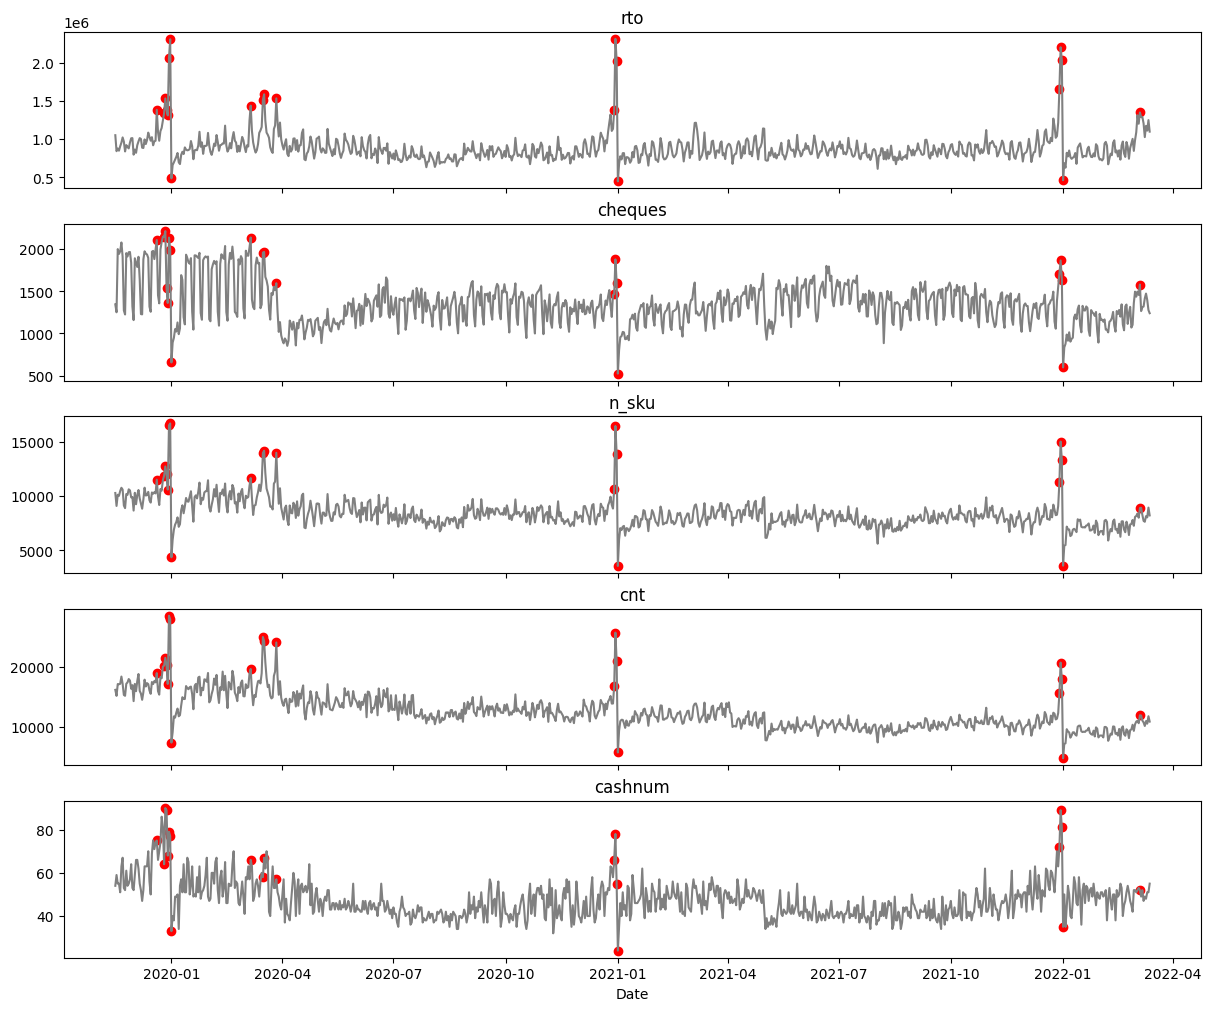

ou: 470


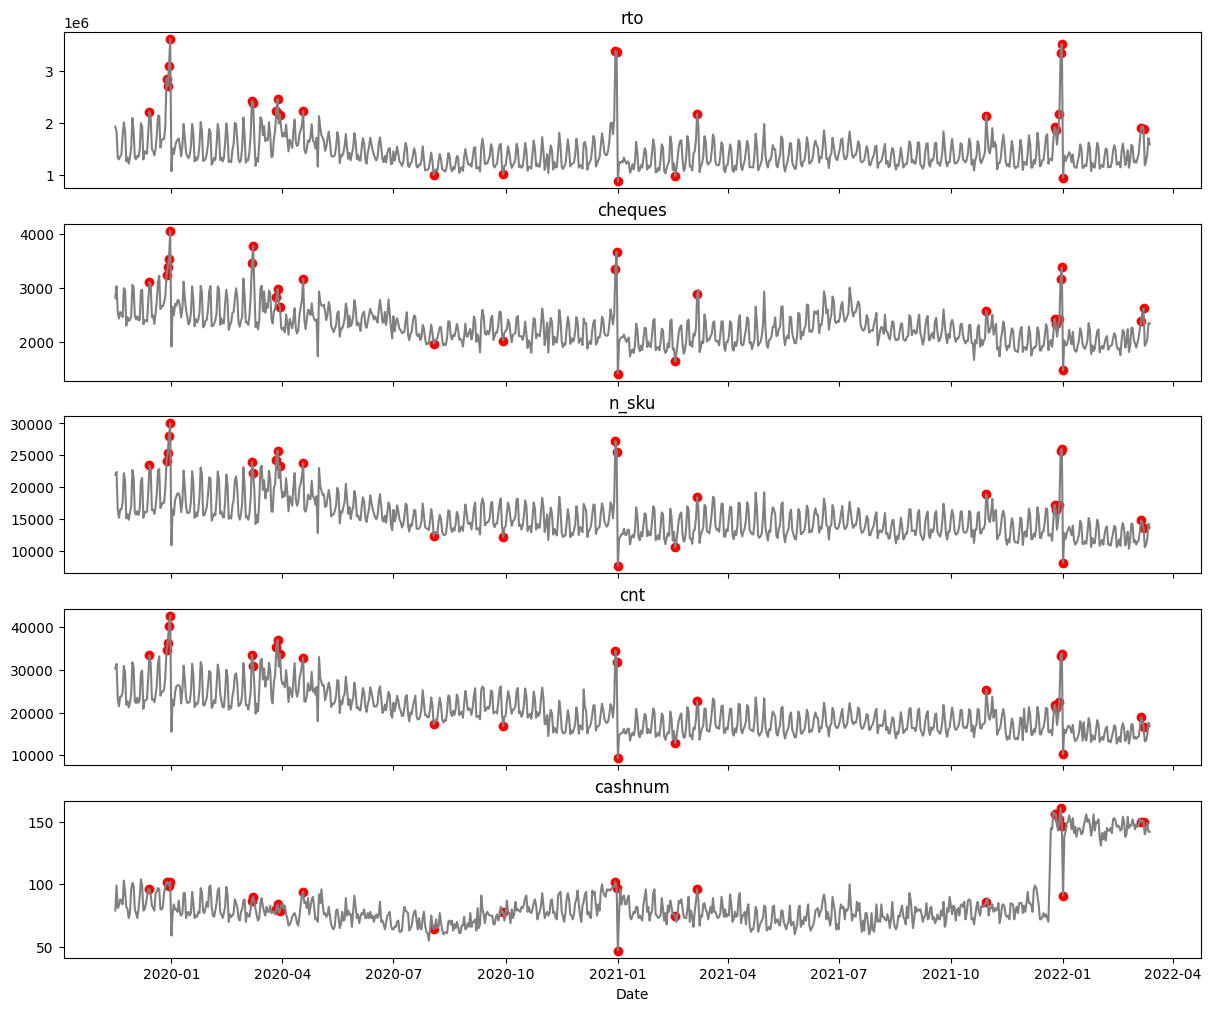

ou: 471


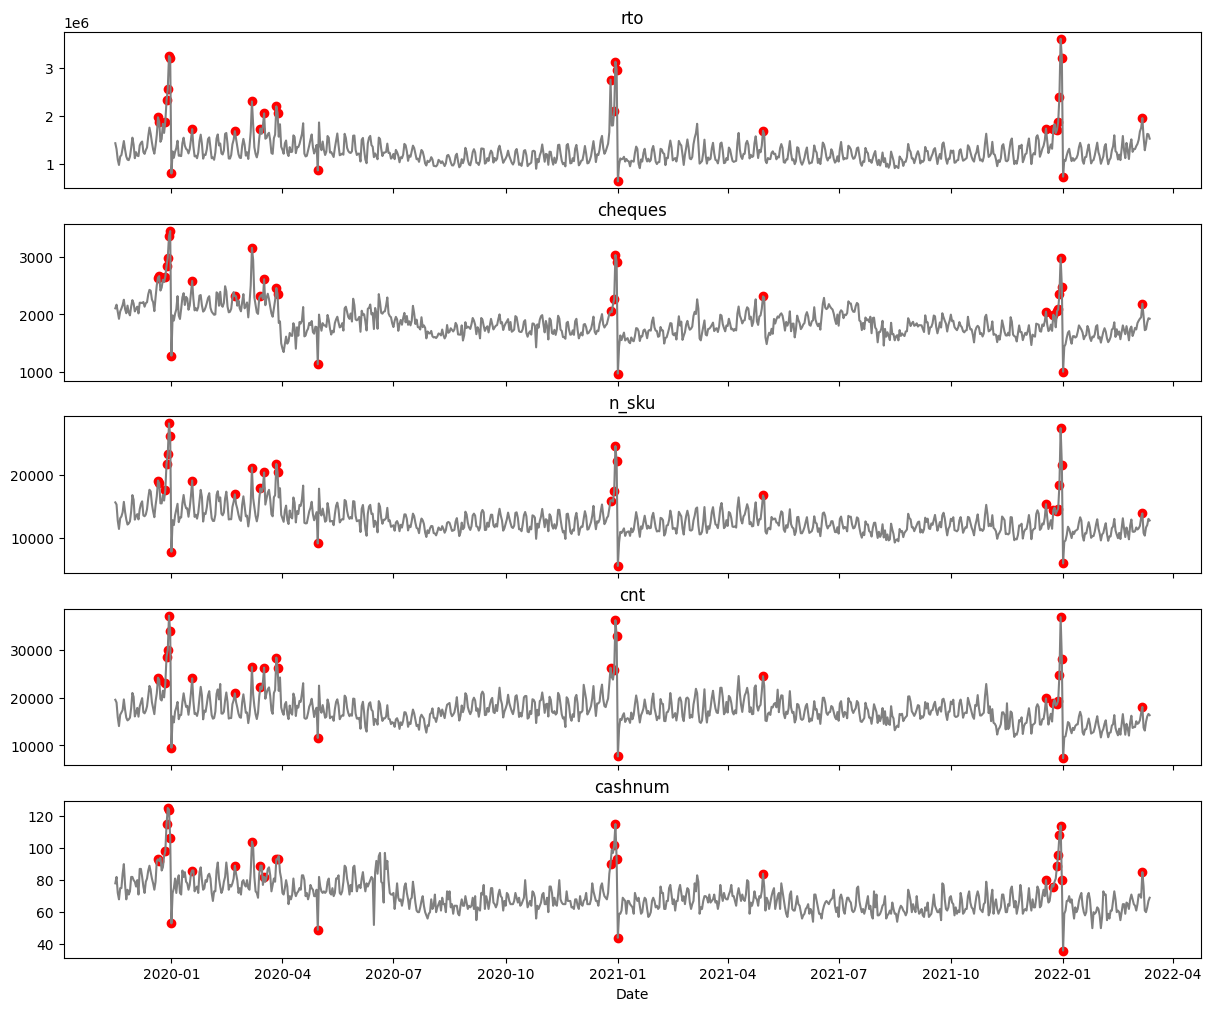

ou: 479


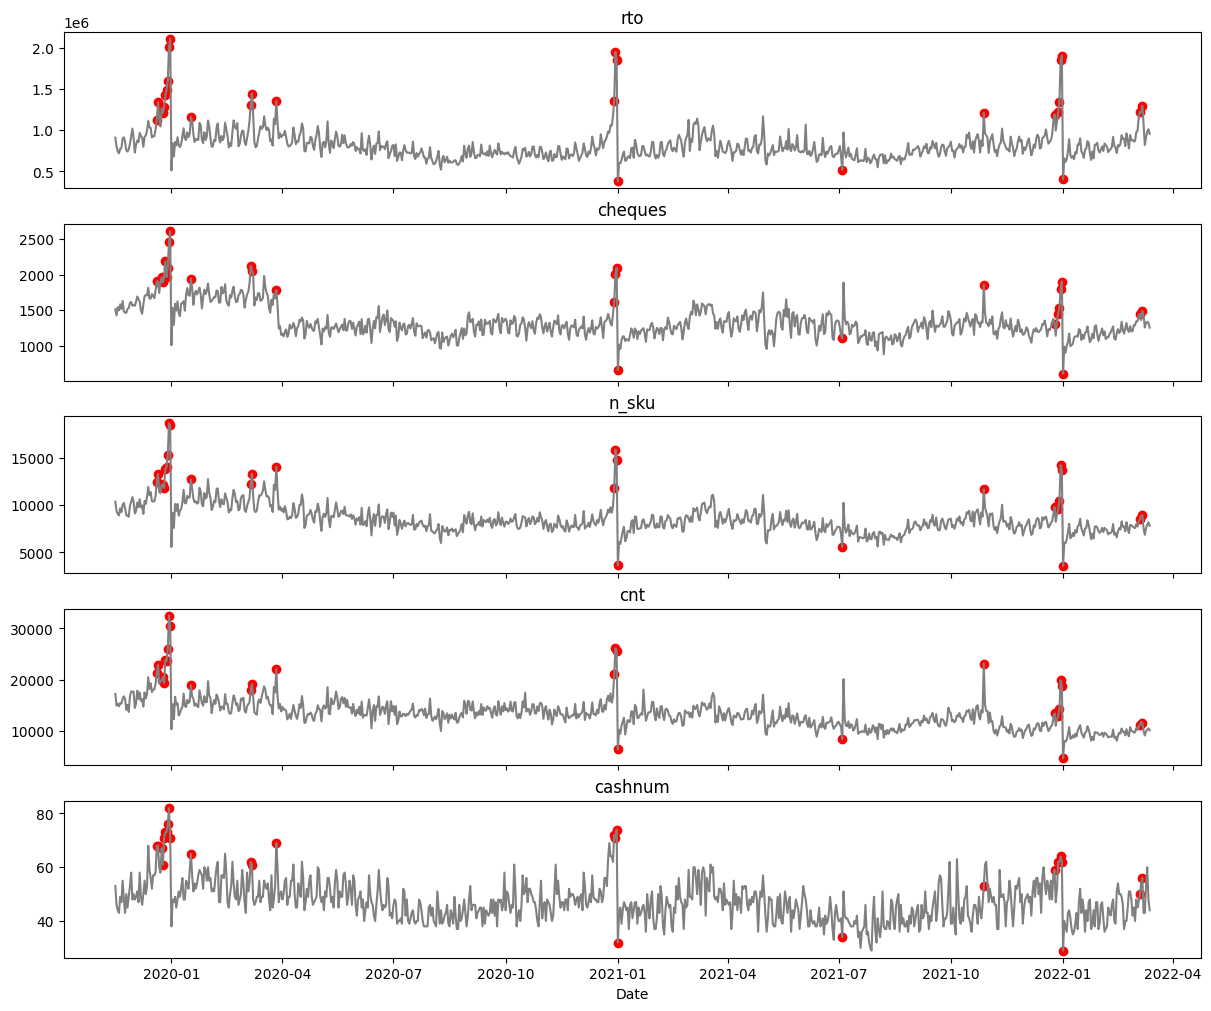

ou: 489


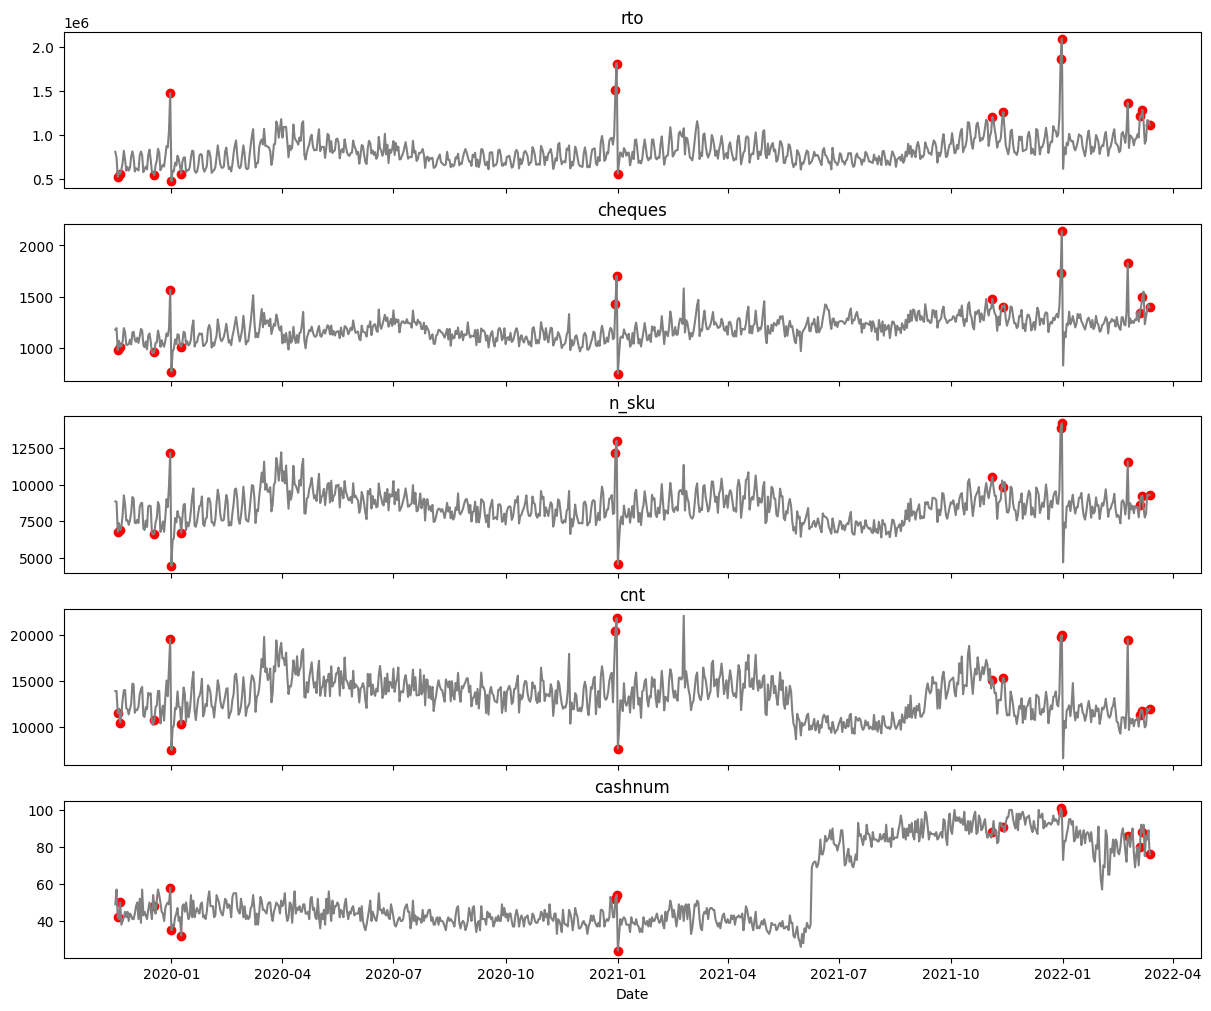

ou: 492


C:\Users\dmibor\miniconda3\envs\practicum\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dmibor\miniconda3\envs\practicum\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\dmibor\miniconda3\envs\practicum\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\dmibor\miniconda3\envs\practicum\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dmibor\miniconda3\envs\practicum\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\U

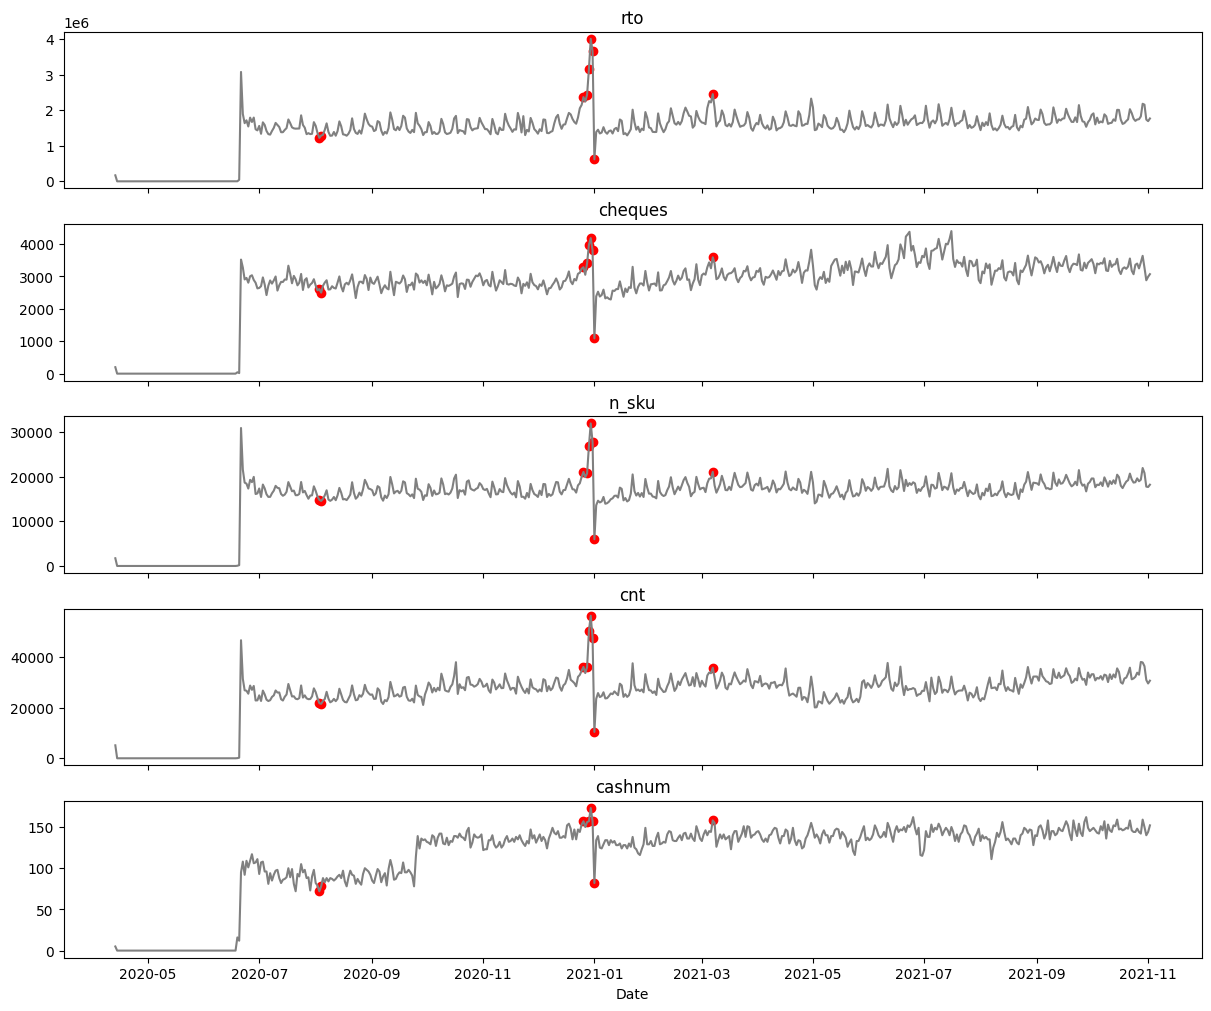

ou: 493


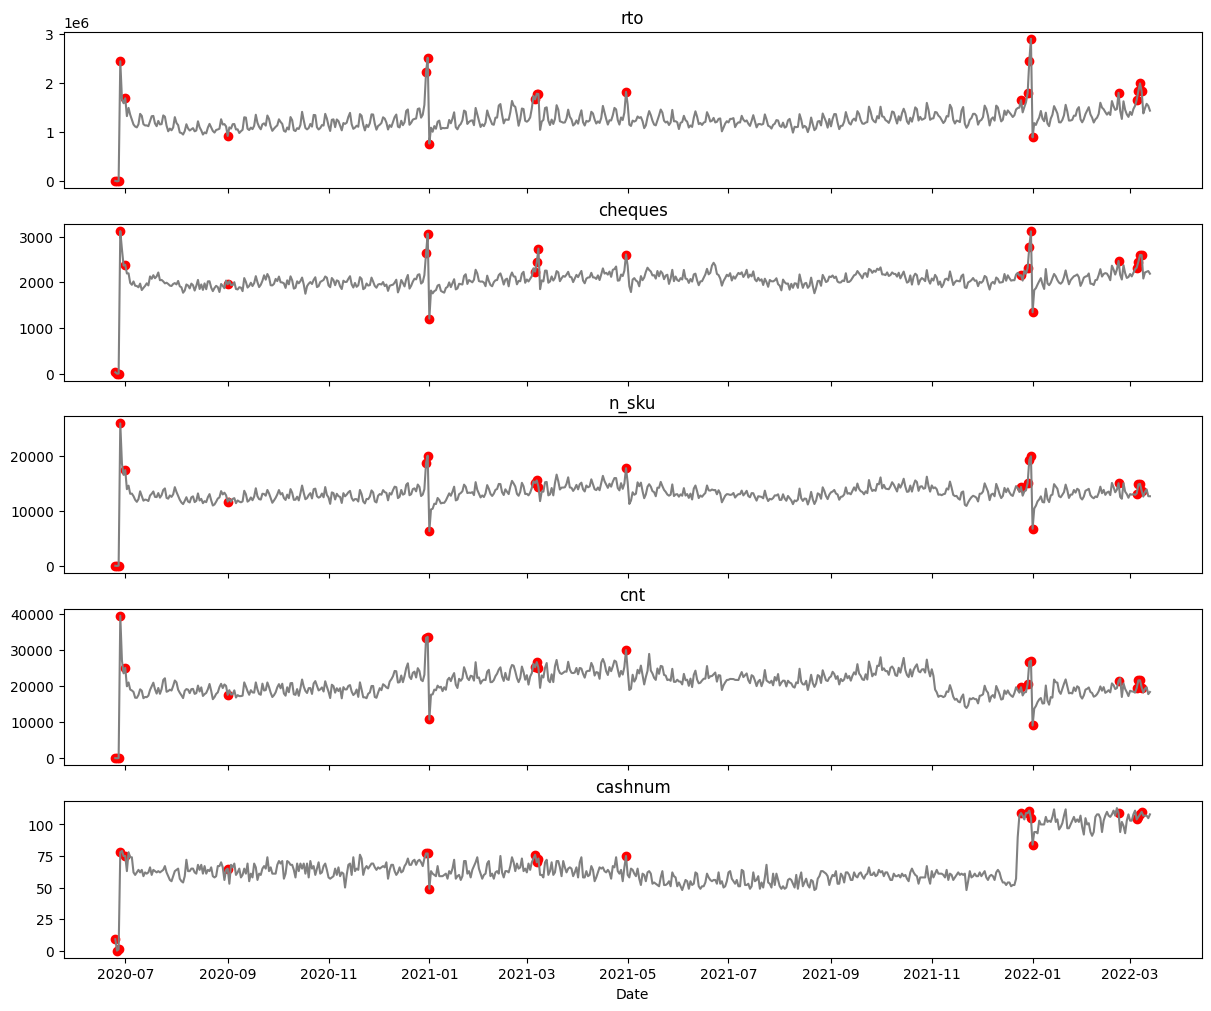

In [50]:
methods= ['anomaly_HBOS', 'anomaly_ABOD','anomaly_lof', 'anomaly_cblof']
def get_amonaly_decision(df_raw, desicion_func='all'):
    cnt= 0 #количество предсказаний о наличии анломалии
    cnt_all= len(methods)
    for col in methods:
        if(df_raw[col]==1):
            cnt=cnt+1
    anomaly_decision= 0 #по умолчанию аномалии нет
    if desicion_func=='all': #все модели указывают на аномалию
        if cnt==cnt_all: 
            anomaly_decision= 1
    elif desicion_func=='max': #большинство (более половины) моделей указывают на аномалию
        if cnt/cnt_all>0.5: 
            anomaly_decision= 1
    else: #desicion_func=='any' #хотя бы одна модель указывает на аномалию
       if cnt>0: 
            anomaly_decision= 1     
    return anomaly_decision

for ou in df.ou.unique():
    print('ou:', int(ou))
    dd = df[df.ou==ou]
    dd = dd.set_index('datetime')
    dd = dd[columns].resample('D').sum()

    X = dd.values

    HBOS_detector.fit(X)
    ABOD_detector.fit(X)
    lof_detector.fit(X)
    cblof_detector.fit(X)

    dd['anomaly_HBOS'] = HBOS_detector.predict(X)
    dd['anomaly_ABOD']=  ABOD_detector.predict(X)
    dd['anomaly_lof']= lof_detector.predict(X)
    dd['anomaly_cblof'] = cblof_detector.predict(X)

    dd['anomaly'] = dd.apply(lambda x: get_amonaly_decision(x, 'max'), axis=1)

    show_plots(dd, columns, 'anomaly')